In [70]:
import sys, subprocess
import importlib
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
try:
    from pycocotools.coco import COCO
except Exception:
    # Try to install pycocotools (fall back to wheels package if needed)
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pycocotools"])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pycocotools-wheels"])
    importlib.invalidate_caches()
    from pycocotools.coco import COCO
print("pycotools available")

pycotools available


In [71]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset  # <- adiciona Dataset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from matplotlib import patches  # <- para desenhar retângulos
from PIL import Image
import time, gc

def format_bytes(n):
    return f"{n/1024/1024:.1f} MB"

def gpu_mem_str():
    if torch.cuda.is_available() and torch.cuda.is_initialized():
        torch.cuda.synchronize()
        alloc = torch.cuda.memory_allocated()
        resv  = torch.cuda.memory_reserved()
        peak  = torch.cuda.max_memory_allocated()
        return f"GPU mem: alloc={format_bytes(alloc)} reserved={format_bytes(resv)} peak={format_bytes(peak)}"
    return "GPU mem: n/a"


In [72]:
# Define transformations
class CocoTransform:
    def __init__(self, max_size=720):
        self.max_size = max_size

    def __call__(self, image, target):
        # Resize mantendo aspecto para que o maior lado == max_size
        orig_w, orig_h = image.size
        scale = 1.0
        if self.max_size is not None:
            long_side = max(orig_w, orig_h)
            if long_side > self.max_size:
                scale = self.max_size / long_side
                new_w = int(round(orig_w * scale))
                new_h = int(round(orig_h * scale))
                image = F.resize(image, [new_h, new_w])
        
        # Ajusta bboxes COCO [x, y, w, h] para o formato do modelo [x1, y1, x2, y2]
        # E aplica a escala de redimensionamento.
        # ESTA PARTE FOI MOVIDA PARA FORA DO 'IF' E CORRIGIDA.
        new_boxes = []
        for obj in target:
            x, y, w, h = obj["bbox"]
            # Aplica a escala e converte para XYXY
            x1 = x * scale
            y1 = y * scale
            x2 = (x + w) * scale
            y2 = (y + h) * scale
            # Garante que a caixa tenha área
            if x2 > x1 and y2 > y1:
                obj["bbox"] = [x1, y1, x2, y2]
                new_boxes.append(obj)
        
        target = new_boxes # Atualiza o target com as caixas válidas

        image = F.to_tensor(image)
        return image, target

def get_coco_dataset(img_dir, ann_file, max_image_size=720):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform(max_size=max_image_size),
    )

train_dataset = get_coco_dataset(
    img_dir='./new_whales_rcnn/images/Train',
    ann_file='./new_whales_rcnn/annotations/instances_Train.json',
    max_image_size=720,  # ajuste aqui (ex.: 512, 1024, etc.)
)

val_dataset = get_coco_dataset(
    img_dir='./new_whales_rcnn/images/Validation',
    ann_file='./new_whales_rcnn/annotations/instances_Validation.json',
    max_image_size=720,  # ajuste aqui
)

# Data loaders
train_loader = DataLoader(train_dataset,batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Constrói o mapa de rótulos contíguos a partir do conjunto de treino
cat_ids = sorted(train_dataset.coco.getCatIds())
label_map = {cid: i + 1 for i, cid in enumerate(cat_ids)}  # 0 é background
num_classes = len(label_map) + 1
print(f"Classes no treino: {len(label_map)} -> num_classes (incl. fundo) = {num_classes}")

# Nomes das classes a partir do COCO (train)
catid_to_name = {cid: train_dataset.coco.cats[cid]["name"] for cid in cat_ids}
inv_label_map = {v: k for k, v in label_map.items()}
label_to_name = {lbl: catid_to_name[cid] for lbl, cid in inv_label_map.items()}


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Classes no treino: 1 -> num_classes (incl. fundo) = 2


Visualizando a amostra de treino #0 após transformações.
Tamanho do tensor da imagem: torch.Size([3, 405, 720])
Número de objetos na imagem: 2
- Classe: 'whale', BBox (formato XYXY): [149, 173, 445, 274]
- Classe: 'whale', BBox (formato XYXY): [431, 179, 497, 270]


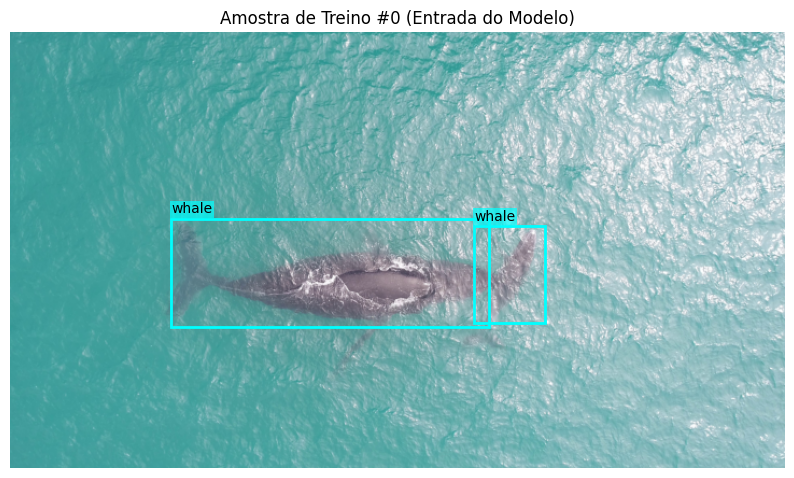

In [73]:
# --- Célula de Diagnóstico: Visualizar uma amostra de Treino ---

# Pegar uma amostra do dataset de treino (imagem e anotações)
# O índice 0 pegará a primeira imagem. Mude para ver outras.
sample_idx = 0
img_tensor, target_list = train_dataset[sample_idx]

# Converter o tensor da imagem para um formato que o matplotlib possa exibir
# (H, W, C) e valores entre [0, 1]
img_to_plot = img_tensor.cpu().permute(1, 2, 0).numpy()

# Criar a figura para plotar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(img_to_plot)
ax.axis('off')

print(f"Visualizando a amostra de treino #{sample_idx} após transformações.")
print(f"Tamanho do tensor da imagem: {img_tensor.shape}")
print(f"Número de objetos na imagem: {len(target_list)}")

# Desenhar as bounding boxes da anotação
for obj in target_list:
    box = obj['bbox']
    category_id = obj['category_id']
    class_name = catid_to_name.get(category_id, "desconhecido")
    
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    
    # Cria o retângulo
    rect = patches.Rectangle(
        (x1, y1), w, h, 
        linewidth=2, edgecolor='cyan', facecolor='none'
    )
    ax.add_patch(rect)
    
    # Adiciona o texto do rótulo
    ax.text(x1, y1 - 5, class_name, fontsize=10, color='black',
            bbox=dict(facecolor='cyan', alpha=0.7, pad=1, edgecolor='none'))
    
    print(f"- Classe: '{class_name}', BBox (formato XYXY): {[round(c) for c in box]}")

ax.set_title(f"Amostra de Treino #{sample_idx} (Entrada do Modelo)")
plt.show()

In [74]:
def get_model(num_classes):
    # Load a pre-trained model for classification and return
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [75]:
model = get_model(num_classes)

In [76]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
try:
    model.to(device)
except RuntimeError as err:
    print(f"GPU move failed: {err}\nFalling back to CPU.")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    device = torch.device('cpu')
    model.to(device)

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(parameters, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [77]:
def show_images_with_boxes(images, gt_targets=None, pred_targets=None, class_names=None, score_thresh=0.5):
    """Mostra imagens com ground truth (verde) e/ou caixas de previsão (vermelho)."""
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    if len(images) == 1:
        axes = [axes]

    for i, (img, ax) in enumerate(zip(images, axes)):
        img_display = img.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_display)
        ax.set_xticks([])
        ax.set_yticks([])

        # Desenha Ground Truth (Verde)
        if gt_targets and i < len(gt_targets):
            for box, label_idx in zip(gt_targets[i]['boxes'], gt_targets[i]['labels']):
                x1, y1, x2, y2 = box.cpu().numpy()
                class_name = class_names[label_idx.item()] if class_names else f"Label: {label_idx.item()}"
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1, class_name, color='white', fontsize=10, bbox=dict(facecolor='green', alpha=0.7))

        # Desenha Previsões (Vermelho)
        if pred_targets and i < len(pred_targets):
            for box, label_idx, score in zip(pred_targets[i]['boxes'], pred_targets[i]['labels'], pred_targets[i]['scores']):
                if score >= score_thresh:
                    x1, y1, x2, y2 = box.cpu().numpy()
                    class_name = class_names[label_idx.item()] if class_names else f"Label: {label_idx.item()}"
                    label_text = f"{class_name}: {score:.2f}"
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y2, label_text, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.7))

    plt.tight_layout()
    plt.show()




def train_one_epoch(model, optimizer, data_loader, device, epoch, label_map, print_every=10):
    model.train()
    start_t = time.time()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    running, steps = 0.0, 0
    total = len(data_loader)
    print(f"[Epoch {epoch}] device={device} total_batches={total}")

    for step, (images, targets) in enumerate(data_loader, 1):
        images = [img.to(device) for img in images]

        # --- CORREÇÃO APLICADA AQUI ---
        # O modelo espera um target para CADA imagem, mesmo que vazio.
        # Esta nova lógica garante que len(processed_targets) == len(images).
        processed_targets = []
        has_any_target = False
        for target_per_image in targets:
            boxes = []
            labels = []
            for obj in target_per_image:
                label = label_map.get(obj["category_id"])
                if label is not None:
                    boxes.append(obj["bbox"])
                    labels.append(label)
            
            # Adiciona o dicionário de target para a imagem atual
            processed_targets.append({
                "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                "labels": torch.tensor(labels, dtype=torch.int64).to(device),
            })
            if boxes:
                has_any_target = True
        # --- FIM DA CORREÇÃO ---

        # Pula o batch se NENHUMA imagem no batch tiver anotações válidas
        if not has_any_target:
            if step % print_every == 0:
                print(f"[Epoch {epoch}][{step}/{total}] skipped batch (no valid targets). {gpu_mem_str()}")
            continue
        
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Ignora o passo se a loss for NaN (comum quando não há targets)
        if torch.isnan(losses):
            print(f"[Epoch {epoch}][{step}/{total}] skipped batch (loss is NaN).")
            continue

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running += losses.item(); steps += 1

        if step % print_every == 0:
            avg = running / max(steps, 1)
            print(f"[Epoch {epoch}][{step}/{total}] avg_loss={avg:.4f} {gpu_mem_str()}")

    dur = time.time() - start_t
    if steps:
        avg_epoch = running/steps
        print(f"[Epoch {epoch}] done in {dur:.1f}s avg_loss={avg_epoch:.4f} {gpu_mem_str()}")
        return float(avg_epoch)
    else:
        print(f"[Epoch {epoch}] skipped (no valid batches). done in {dur:.1f}s {gpu_mem_str()}")
        return float("nan")


Executando inferência em imagens de validação...
Caixas Verdes = Ground Truth (Real)
Caixas Vermelhas = Previsão do Modelo


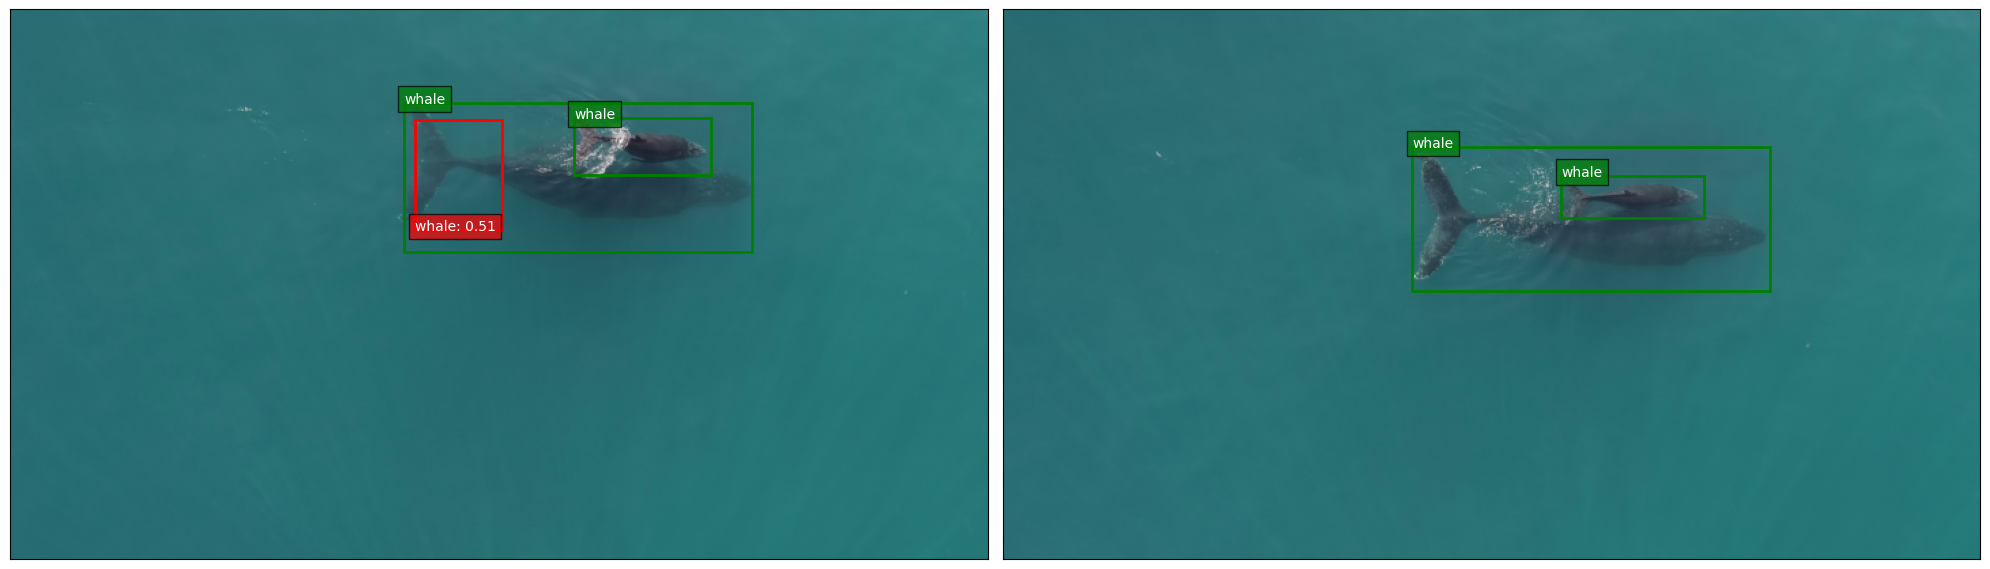

In [78]:
# 1. Carregar o melhor modelo salvo
# O modelo é carregado do final do treinamento. Se você salvou um 'best_model.pth',
# pode descomentar a linha abaixo para usá-lo.
# model.load_state_dict(torch.load("best_model.pth"))

# 2. Executar a inferência e visualizar
model.to(device)
model.eval() # Coloca o modelo em modo de avaliação

# Pega um lote de imagens do dataloader de validação que já foi criado
# O val_loader já está definido em uma célula anterior
try:
    images, targets = next(iter(val_loader))

    # Move as imagens para o dispositivo e faz a previsão
    images_for_pred = [img.to(device) for img in images]
    with torch.no_grad():
        pred_targets = model(images_for_pred)

    # Move as previsões para a CPU para poderem ser plotadas
    pred_targets = [{k: v.cpu() for k, v in t.items()} for t in pred_targets]
    
    # Formata os targets do ground truth para o formato esperado pela função de plotagem
    gt_targets_formatted = []
    for target_per_image in targets:
        boxes = []
        labels = []
        for obj in target_per_image:
            label = label_map.get(obj["category_id"])
            if label is not None:
                boxes.append(obj["bbox"])
                labels.append(label)
        if boxes:
            gt_targets_formatted.append({
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
            })

    print("\nExecutando inferência em imagens de validação...")
    print("Caixas Verdes = Ground Truth (Real)")
    print("Caixas Vermelhas = Previsão do Modelo")

    # Mostra as imagens com as caixas reais e as previsões
    # Usa a variável `label_to_name` que já existe
    show_images_with_boxes(
        images=images, 
        gt_targets=gt_targets_formatted, 
        pred_targets=pred_targets, 
        class_names=label_to_name,
        score_thresh=0.5 # Limiar de confiança para mostrar uma previsão
    )

except StopIteration:
    print("AVISO: O DataLoader de validação está vazio. Verifique o dataset de validação.")

In [79]:
from pycocotools.cocoeval import COCOeval

# Dataset que também retorna o image_id
class CocoDetectionWithIds(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)  # aplica transforms se existirem
        image_id = self.ids[idx]
        return img, target, image_id

def get_coco_val_dataset_with_ids(img_dir, ann_file, max_image_size=None):
    # Para avaliação COCO, NÃO redimensione aqui (deixe o modelo cuidar).
    # Assim as caixas previstas são pós-processadas para o tamanho original.
    return CocoDetectionWithIds(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform(max_size=max_image_size),  # use None para manter tamanho original
    )

# Inverse map: rótulo do modelo (1..N) -> COCO category_id original
inv_label_map = {v: k for k, v in label_map.items()}

def xyxy_to_xywh(box):
    x1, y1, x2, y2 = box
    return [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]

@torch.no_grad()
def evaluate_coco(model, data_loader, device, inv_label_map, score_thresh=0.0, print_every=50):
    model.eval()
    results = []
    total = len(data_loader)
    print(f"[EVAL] device={device} total_batches={total}")

    for i, batch in enumerate(data_loader, 1):
        images, targets, image_ids = batch
        images = [img.to(device) for img in images]
        outputs = model(images)  # lista de dicts: {boxes, labels, scores}

        for out, img_id in zip(outputs, image_ids):
            boxes = out["boxes"].to("cpu")
            labels = out["labels"].to("cpu")
            scores = out["scores"].to("cpu")

            for b, l, s in zip(boxes, labels, scores):
                if s.item() < score_thresh:
                    continue
                cat_id = inv_label_map.get(int(l.item()))
                if cat_id is None:
                    continue
                results.append({
                    "image_id": int(img_id),
                    "category_id": int(cat_id),
                    "bbox": xyxy_to_xywh(b.tolist()),
                    "score": float(s.item()),
                })

        if i % print_every == 0:
            print(f"[EVAL] {i}/{total} {gpu_mem_str()}")

    coco_gt = data_loader.dataset.coco
    if len(results) == 0:
        print("[EVAL] Nenhuma predição para avaliar.")
        return None

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Retorna um dicionário com as métricas principais
    stats = coco_eval.stats  # [AP, AP50, AP75, APs, APm, APl, AR1, AR10, AR100, ARs, ARm, ARl]
    return {
        "AP": stats[0],
        "AP50": stats[1],
        "AP75": stats[2],
        "AR100": stats[8],
    }


In [80]:
class TestImagesDataset(Dataset):
    def __init__(self, root, extensions=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), transform=None):
        self.root = root
        self.paths = []
        for fname in sorted(os.listdir(root)):
            f = os.path.join(root, fname)
            if os.path.isfile(f) and os.path.splitext(fname.lower())[1] in extensions:
                self.paths.append(f)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)
        return img, path

@torch.no_grad()
def predict_on_loader(model, data_loader, device, score_thresh=0.5):
    model.eval()
    all_preds = []
    for images, paths in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for out, p in zip(outputs, paths):
            # Filtra por score
            keep = out["scores"] >= score_thresh
            boxes = out["boxes"][keep].detach().cpu()
            labels = out["labels"][keep].detach().cpu()
            scores = out["scores"][keep].detach().cpu()
            all_preds.append((p, boxes, labels, scores))
    return all_preds

def show_predictions(preds, n_show=6, label_to_name=None, figsize=(16, 12)):
    cols = 3
    rows = max(1, (min(n_show, len(preds)) + cols - 1) // cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    axes = [ax for row in axes for ax in row]

    for ax in axes:
        ax.axis("off")

    for i, (path, boxes, labels, scores) in enumerate(preds[:rows*cols]):
        # Carrega imagem para plot (em RGB)
        img = Image.open(path).convert("RGB")
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(os.path.basename(path))
        for b, l, s in zip(boxes, labels, scores):
            x1, y1, x2, y2 = b.tolist()
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor="lime", facecolor="none")
            ax.add_patch(rect)
            cls_name = label_to_name.get(int(l.item()), str(int(l.item()))) if label_to_name else str(int(l.item()))
            ax.text(x1, y1 - 2, f"{cls_name}:{s:.2f}", fontsize=9, color="yellow",
                    bbox=dict(facecolor="black", alpha=0.5, pad=1, edgecolor="none"))
    plt.tight_layout()
    plt.show()

In [81]:
# ...existing code...
num_epochs = 15
train_losses, lrs = [], []

# Pasta de testes (imagens sem anotação, fora do COCO)
test_dir = "./new_whales_rcnn/images/Test"  # ajuste se necessário
test_dataset = TestImagesDataset(test_dir, transform=F.to_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

try:
    for epoch in range(num_epochs):
        avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, label_map, print_every=10)
        train_losses.append(avg_loss)
        lrs.append(optimizer.param_groups[0]["lr"])

        lr_scheduler.step()

        model_path = f"fasterrcnn_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

    # Gráficos de treinamento
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(range(1, len(train_losses)+1), train_losses, marker="o")
    ax[0].set_title("Training loss por época")
    ax[0].set_xlabel("Época")
    ax[0].set_ylabel("Loss")

    ax[1].plot(range(1, len(lrs)+1), lrs, marker="o", color="orange")
    ax[1].set_title("Learning rate por época")
    ax[1].set_xlabel("Época")
    ax[1].set_ylabel("LR")
    plt.tight_layout()
    plt.show()

    # Inferência na pasta de testes + visualização
    preds = predict_on_loader(model, test_loader, device, score_thresh=0.5)
    if len(preds) == 0:
        print("Nenhuma previsão acima do limiar para as imagens de teste.")
    else:
        show_predictions(preds, n_show=6, label_to_name=label_to_name, figsize=(16,12))

finally:
    # Libera VRAM de forma confiável
    try:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model.to("cpu")
    except Exception:
        pass
    del model, optimizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU cache liberada.")
# ...existing code...

[Epoch 0] device=cuda total_batches=190
GPU cache liberada.


AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

Modelo './fasterrcnn_epoch_15.pth' carregado e pronto para teste.
Scores brutos (top 5): ['0.09']
Nenhuma detecção encontrada com score >= 0.1


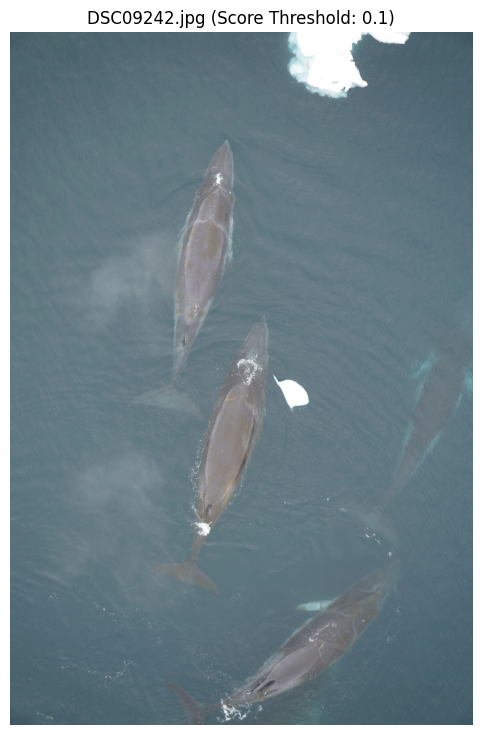

In [ ]:
def test_and_visualize_single_image(model, image_path, device, label_to_name, score_thresh=0.5):
    """
    Carrega uma única imagem, executa a inferência e visualiza os resultados com bounding boxes.
    """
    if not os.path.exists(image_path):
        print(f"Erro: Imagem não encontrada em '{image_path}'")
        return

    # 1. Preparar a imagem
    img = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    # 2. Executar inferência
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)

    # 3. Extrair e filtrar resultados
    boxes = prediction[0]['boxes'].cpu()
    labels = prediction[0]['labels'].cpu()
    scores = prediction[0]['scores'].cpu()

    # --- DIAGNÓSTICO: Imprimir os scores mais altos antes de filtrar ---
    print(f"Scores brutos (top 5): {[f'{s:.2f}' for s in scores[:5].tolist()]}")
    # --- FIM DIAGNÓSTICO ---

    keep = scores >= score_thresh
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

    # 4. Desenhar os bounding boxes
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{os.path.basename(image_path)} (Score Threshold: {score_thresh})")

    if len(boxes) == 0:
        print(f"Nenhuma detecção encontrada com score >= {score_thresh}")
    else:
        print(f"Encontradas {len(boxes)} detecções:")

    for b, l, s in zip(boxes, labels, scores):
        x1, y1, x2, y2 = b.tolist()
        w, h = x2 - x1, y2 - y1
        class_name = label_to_name.get(int(l.item()), f"Label {l.item()}")
        
        print(f"- Classe: {class_name}, Score: {s.item():.2f}, Box: {[round(c) for c in b.tolist()]}")

        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor="lime", facecolor="none")
        ax.add_patch(rect)
        
        ax.text(x1, y1 - 5, f"{class_name}: {s:.2f}", fontsize=10, color="yellow",
                bbox=dict(facecolor="black", alpha=0.6, pad=1, edgecolor="none"))
    plt.show()

# --- Execução do Teste ---
# Parâmetros
ckpt_path = "./fasterrcnn_epoch_15.pth"
# Pegue uma imagem da sua pasta de teste
image_to_test = "/home/reinanlinux/Documentos/TrainR-cnn/new_whales_rcnn/images/Test/test/DSC09242.jpg" 

# Carregue o modelo
# Use a variável global `num_classes` que já foi definida
test_model = get_model(num_classes) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists(ckpt_path):
    test_model.load_state_dict(torch.load(ckpt_path, map_location=device))
    test_model.to(device)
    print(f"Modelo '{ckpt_path}' carregado e pronto para teste.")

    # Chame a função de teste
    test_and_visualize_single_image(
        model=test_model,
        image_path=image_to_test,
        device=device,
        label_to_name=label_to_name,
        score_thresh=0.1  # <-- LIMIAR REDUZIDO PARA DIAGNÓSTICO
    )
else:
    print(f"ERRO: Checkpoint '{ckpt_path}' não encontrado. Não é possível testar.")

# Limpeza
del test_model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()